PPCA lavora con più variabili osservabili anzichè una sola

In [22]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import scipy

In [2]:
scaler = StandardScaler()

In [3]:
data = np.load('prova.npy', allow_pickle=True).item()

## test with new data

In [4]:
import deepemogp.feature_extractor as feature_extractor
import deepemogp.signal.physio as physio
import deepemogp.signal.face as face
import deepemogp.signal.annotation as annotation
import deepemogp.datasets as datasets
import deepemogp.signal.behavior as behavior

# from: https://github.com/SheffieldML/GPy
#import GPy
# from: https://github.com/SheffieldML/PyDeepGP
#import deepgp

import pandas as pd
import numpy as np

show = False
# definition of the feature extractors to be used later
f1 = feature_extractor.FE('wavelet')
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(2, 1))

# definition of the physiological signals to be extracted
eda = physio.EDA(f3)
hr = physio.HR(f3)

pupil = behavior.PUPIL(f3)

# definition of the emotional annotation to be extracted
#va = annotation.VA('valence', f3)
#ar = annotation.VA('arousal', f3)
# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr,pupil}, subjects={'2'})

for s in d.signals:
    # preprocess ...
    #s.preprocess(show=show)

    # ... and extract features from each signal type
    s.feature_ext.extract_feat_without_preprocess(s, show=show)

hr_data = list(d.signals)[0].features[:4]
pupil_data = list(d.signals)[1].features[:4]

print(pupil_data)
print()
print(hr_data)

>> Loading PUPIL for subject 2 and all sessions from dataset FEAR
>> Loading HR for subject 2 and all sessions from dataset FEAR
>> Extracting mean features from PUPIL signal, adopting (2, 1) window ...
>> Extracting mean features from HR signal, adopting (2, 1) window ...
          0
0 -0.002085
1 -0.002064
2 -0.002355
3 -0.005520

          0
0  2.176351
1  2.134074
2  2.159014
3  2.186318


## end test

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variabilty
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

gaze =

In [5]:
gaze = pupil_data
hr = hr_data
#eda = data['eda']
'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


"social_anx = data['social anxiety'][:,np.newaxis]\npain_exp = data['pain expectation'][:,np.newaxis]"

In [6]:
print(gaze.shape)
print(hr.shape)

(4, 1)
(4, 1)


In [7]:
N_gaze = gaze.shape[0]
D_gaze = gaze.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

#N_eda = eda.shape[0]
#D_eda = eda.shape[1]
K = 1

print(gaze.T)
print()
print(hr.T)

          0         1         2        3
0 -0.002085 -0.002064 -0.002355 -0.00552

          0         1         2         3
0  2.176351  2.134074  2.159014  2.186318


In [12]:
with pm.Model() as sPPCA:
    #dati osservabili
    gaze_data = pm.MutableData("gaze_data", gaze.T)
    hr_data = pm.MutableData("hr_data", hr.T)
    #eda_data = pm.MutableData("eda_data", eda.T)

    #matrici pesi
    Wgaze = pm.Normal('Wgaze', mu=at.zeros([D_gaze, K]), sigma=2.0 * at.ones([D_gaze, K]), shape=[D_gaze, K])
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    #Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    #latent space
    c = pm.Normal('c', mu=at.zeros([N_gaze, K]), sigma=at.ones([N_gaze, K]), shape=[N_gaze, K])

    x_gaze = pm.Normal('x_gaze', mu=Wgaze.dot(c.T), sigma=at.ones([D_gaze, N_gaze]), shape=[D_gaze, N_gaze], observed=gaze_data)
    x_hr = pm.Normal('x_hr', mu=Whr.dot(c.T), sigma=at.ones([D_hr,N_hr]) ,shape=[D_hr, N_hr], observed=hr_data)
    #x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [13]:
'''gv = pm.model_to_graphviz(sPPCA)
gv.view()'''

'gv = pm.model_to_graphviz(sPPCA)\ngv.view()'

In [14]:
sPPCA.free_RVs

[Wgaze ~ N(f(), f()), Whr ~ N(f(), f()), c ~ N(f(), f())]

In [15]:
with sPPCA:
    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 300
Interrupted at 299 [0%]: Average Loss = 19.287
Sequential sampling (1 chains in 1 job)
NUTS: [Wgaze, Whr, c]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6015, but should be close to 0.8. Try to increase the number of tuning steps.


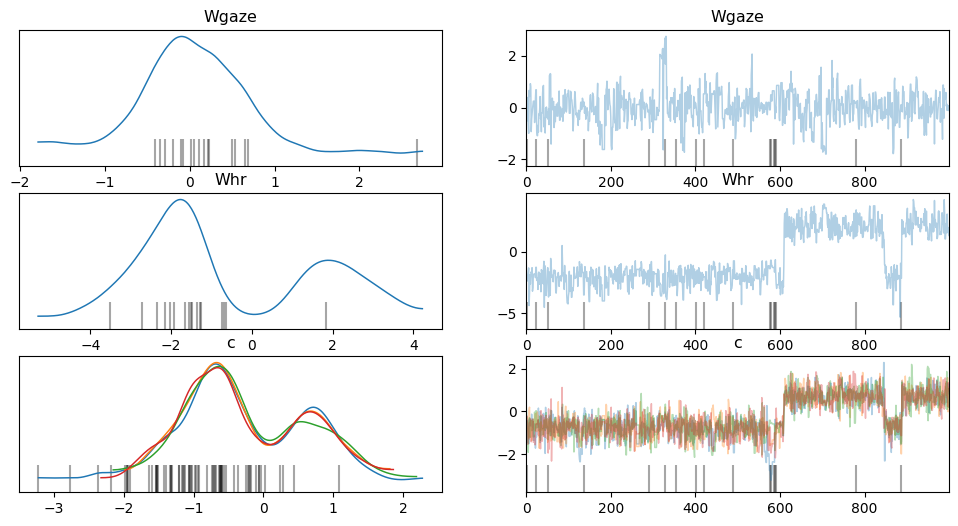

In [16]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace)
plt.show()

In [17]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"gaze_data": gaze})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
hr_pred = posterior_predictive.posterior_predictive["x_hr"]

Sampling: [x_gaze, x_hr]


In [ ]:
gaze

In [ ]:
print(hr_pred[0])

In [ ]:
print(hr_pred[0].shape)

In [ ]:
print(float(np.mean(hr_pred[0])))

In [18]:
hr_pred_mode = (stats.median_abs_deviation(hr_pred[0]))[0]
hr_pred_mode

array([0.91123809, 0.88691911, 1.00878231, 0.90381311])

In [21]:
hr[0]

0    2.176351
1    2.134074
2    2.159014
3    2.186318
Name: 0, dtype: float64

In [19]:
hr_pred_mode= pd.Series([0.006,0.01,0.02,0.003])

hr and hr_pred_mode devono avere same shape

In [27]:
train_accuracy_hr = np.mean(np.subtract(hr[0], hr_pred_mode))
print('\n\t avg distance hr: ' + str(train_accuracy_hr))
#print(' ')


	 avg distance hr: 2.15418921292833


In [33]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
    gaze_pred = posterior_predictive.posterior_predictive["x_gaze"]

Sampling: [x_gaze, x_hr]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data


In [34]:
gaze_pred

<xarray.DataArray 'x_gaze' (chain: 1, draw: 1000, x_gaze_dim_0: 1,
                            x_gaze_dim_1: 4)>
array([[[[-0.77354881, -0.32712617, -0.02050724, -0.15589055]],

        [[ 0.89413367,  0.42506441, -0.65890353,  0.52353865]],

        [[-1.45377925,  0.41934786,  0.6936445 ,  0.17476148]],

        ...,

        [[ 0.89848344, -0.90545517,  0.48953356, -0.16467811]],

        [[-1.37427076,  0.16942351,  0.78447548, -1.2418062 ]],

        [[-1.15328791, -0.42480544, -0.37361602, -0.35417937]]]])
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * x_gaze_dim_0  (x_gaze_dim_0) int64 0
  * x_gaze_dim_1  (x_gaze_dim_1) int64 0 1 2 3

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = gaze.reshape(-1)
reconstructed_r2 = r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))

In [ ]:
import deepemogp.feature_extractor as feature_extractor

In [ ]:
f = feature_extractor.FE('wavelet', window=(8,6), params={'w_mother':'db3','w_maxlev':1})

In [ ]:
x = [3, 7, 1, 1, -2, 5, 4, 6]

In [ ]:
f.apply(x)